In [59]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import keras
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from keras.layers import *
from pathlib import Path
from keras.models import load_model

sc = MinMaxScaler(feature_range = (-1, 1))

#####################
def load_dataset(filename):
    try:
        df = pd.read_csv(filename)
        df['date'] = pd.to_datetime(df.date)
        df.set_index('date', inplace=True)
        df = df.iloc[:,:4]
        df = df.replace(',','', regex=True).astype(float)
        df = df.sort_index(ascending=True)
        return df
    except Exception as e:
        print("Exception in loading dataset: ",e)
#####################       
def split_data(df,split_percent):
    try:
       
        training_set = sc.fit_transform(df)

        train_size = int(len(training_set)*split_percent)
        test_size = len(training_set) - train_size
        train_data = training_set[0:train_size,:]
        test_data = training_set[train_size:len(training_set),:]

        return train_data,test_data
    
    except Exception as e:
        print("Exception Spliting Data: ",e)
    
#####################
def create_dataSet(dataset,past,future):
    X_train, y_train = [],[]
    try:
        for i in range(past, len(dataset) - future +1):

            
            X_train.append(dataset[i - past:i, 0 : dataset.shape[1] - 1])

            y_train.append(dataset[i + future - 1:i + future, 3]) # 3 = close price

        return np.array(X_train), np.array(y_train)
    
    except Exception as e:
        print("Exception in Creating Dataset: ",e)
#####################
def lstm_predict(X_train,y_train,epochs,batch_size,past):
    try:
        model = Sequential()
        
        # Adding 1st LSTM layer
        model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

#         # Adding 2nd LSTM layer
#         model.add(LSTM(units=64, return_sequences=True))
        
        # Adding 3rd LSTM layer
        model.add(LSTM(units=32, return_sequences=False))
        
        # Adding Dropout
        model.add(Dropout(0.1))

        # Output layer based upon y_train (the number of col needs to be predicted)
        model.add(Dense(y_train.shape[1]))

        # Compiling the Neural Network
        model.compile(loss='mse',optimizer="adam", metrics=['mae', 'mape'])


        history = model.fit(X_train, y_train, epochs = epochs,
                            batch_size = batch_size,validation_split=0.1)

        return history , model
    
    except Exception as e:
        print("Exception in LSTM model training: ",e)
######################
def forecast(model,future_days,dataset):
    try:

        ## Get date from dataset
        dates = pd.to_datetime(dataset.index)

        ##Split data so that It can be used to predict
        train,test = split_data(dataset,1)
        x_all , y_all = create_dataSet(train,10,1)

        ## Make date range ahead of last date in dataset
        forecast_period_dates = pd.date_range(list(dates)[-1], periods=future_days, freq='B').tolist()

        ## Make future prediction (future days)
        forecast = model.predict(x_all[-future_days:]) #forecast

        ## convert into shape of dataset so that it can inverse transformed
        forecast_copies = np.repeat(forecast, dataset.shape[1], axis=-1)

        y_pred_future = sc.inverse_transform(forecast_copies)[:,0] # Inverse transform

        # Convert timestamp to date
        forecast_dates = []
        for time_i in forecast_period_dates:
            forecast_dates.append(time_i.date())

        ## Make dataframe of forecasted values along with future dates    
        df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Close':y_pred_future})

        ## Convert date time
        df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


        return df_forecast
    except Exception as f:
        print("Exception in forecast: ",f)
#####################
def return_future_dateRange(df,future_days):
    try:
        # Take last day from data set and make a date range only for business days 
        datelist = pd.date_range(df.index[-1], periods=future,freq='B').to_list()

        datelist_future = [] 

        #Get only date from datelist 
        for this_timestamp in datelist:
            datelist_future.append(this_timestamp.date())

        return datelist_future
    
    except Exception as e:
        print("Exception in Generating Future Date Range: ",e)
##########################
def save_model(model,h5_filename):
    
    model.save('./LSTM_MODELS/'+h5_filename+'.h5')
#########################

# Main function that takes following parameters and return a trained model 
def start_process(filename,past,future,batch_size,epochs,split_percent):

    df = load_dataset(filename) # load dataset
    train_data,test_data = split_data(df,split_percent) # split data
    
    X_train , y_train = create_dataSet(train_data,past,future) # Splitting data to x and y train
    
    print('Train Data shape = {}.'.format(train_data.shape))
    print('Test Data shape = {}.'.format(test_data.shape),'\n')

    print('X_train shape = {}.'.format(X_train.shape))
    print('y_train shape = {}.'.format(y_train.shape))
    
    history, model = lstm_predict(X_train,y_train,epochs,batch_size,past)
    
    return model,history

## KSE 100 Index 

In [10]:
df_kse100 = load_dataset("./indexData/KSE-100.csv") # Load dataset

train_dates = pd.to_datetime(df_100.index) # Get dates from dataframe

train_data_100,test_data_100 = split_data(df_100,0.75) # 75% training and 25% testing

past = 5 # Number of past days we want to use to predict the future
future = 1 # Number of days we want top predict into the future
batch_size = 32  # Look at the past_days of data collectively to identify features
epochs = 100 

X_train_100 , y_train_100 = create_dataSet(train_data_100,past,future) # Splitting data to x and y train

print('X_train shape = {}.'.format(X_train_100.shape))
print('y_train shape = {}.'.format(y_train_100.shape))

## Call Function with all parameters and get a model ( For testing purpose )
history, model_kse100 = lstm_predict(X_train_100,y_train_100,epochs,batch_size,past) 

X_train shape = (3790, 5, 3).
y_train shape = (3790, 1).
Epoch 1/100
107/107 [==============================] - 6s 21ms/step - loss: 0.0900 - mae: 0.2012 - mape: 61.4469 - val_loss: 0.0117 - val_mae: 0.1053 - val_mape: 44.0656
Epoch 2/100
107/107 [==============================] - 1s 9ms/step - loss: 0.0029 - mae: 0.0417 - mape: 18.1763 - val_loss: 0.0040 - val_mae: 0.0586 - val_mape: 24.0143
Epoch 3/100
107/107 [==============================] - 1s 10ms/step - loss: 0.0025 - mae: 0.0380 - mape: 12.0605 - val_loss: 0.0023 - val_mae: 0.0436 - val_mape: 17.9426
Epoch 4/100
107/107 [==============================] - 1s 9ms/step - loss: 0.0022 - mae: 0.0355 - mape: 9.7983 - val_loss: 0.0016 - val_mae: 0.0349 - val_mape: 14.4174
Epoch 5/100
107/107 [==============================] - 1s 9ms/step - loss: 0.0020 - mae: 0.0340 - mape: 8.4870 - val_loss: 0.0013 - val_mae: 0.0316 - val_mape: 13.1665
Epoch 6/100
107/107 [==============================] - 1s 9ms/step - loss: 0.0019 - mae: 0.0329 - 

Epoch 48/100
107/107 [==============================] - 1s 10ms/step - loss: 5.9702e-04 - mae: 0.0184 - mape: 10.2513 - val_loss: 4.5574e-04 - val_mae: 0.0165 - val_mape: 7.7130
Epoch 49/100
107/107 [==============================] - 1s 10ms/step - loss: 5.9287e-04 - mae: 0.0180 - mape: 9.0419 - val_loss: 7.6940e-04 - val_mae: 0.0230 - val_mape: 10.0039
Epoch 50/100
107/107 [==============================] - 1s 10ms/step - loss: 6.0314e-04 - mae: 0.0183 - mape: 10.1961 - val_loss: 5.2658e-04 - val_mae: 0.0178 - val_mape: 8.3995
Epoch 51/100
107/107 [==============================] - 1s 10ms/step - loss: 6.0070e-04 - mae: 0.0183 - mape: 10.1818 - val_loss: 4.9758e-04 - val_mae: 0.0175 - val_mape: 7.9958
Epoch 52/100
107/107 [==============================] - 1s 12ms/step - loss: 6.0782e-04 - mae: 0.0185 - mape: 8.6366 - val_loss: 6.1303e-04 - val_mae: 0.0194 - val_mape: 9.0903
Epoch 53/100
107/107 [==============================] - 2s 14ms/step - loss: 5.7100e-04 - mae: 0.0180 - mape: 1

107/107 [==============================] - 1s 9ms/step - loss: 4.2687e-04 - mae: 0.0142 - mape: 10.9622 - val_loss: 6.0323e-04 - val_mae: 0.0192 - val_mape: 9.0801
Epoch 95/100
107/107 [==============================] - 1s 10ms/step - loss: 3.6227e-04 - mae: 0.0134 - mape: 19.2906 - val_loss: 3.9975e-04 - val_mae: 0.0156 - val_mape: 7.0813
Epoch 96/100
107/107 [==============================] - 1s 10ms/step - loss: 4.0687e-04 - mae: 0.0143 - mape: 11.8324 - val_loss: 3.3255e-04 - val_mae: 0.0138 - val_mape: 6.4802
Epoch 97/100
107/107 [==============================] - 1s 11ms/step - loss: 3.2452e-04 - mae: 0.0130 - mape: 8.0490 - val_loss: 0.0015 - val_mae: 0.0350 - val_mape: 14.8752
Epoch 98/100
107/107 [==============================] - 2s 15ms/step - loss: 3.7650e-04 - mae: 0.0137 - mape: 11.2965 - val_loss: 3.7307e-04 - val_mae: 0.0147 - val_mape: 6.9478
Epoch 99/100
107/107 [==============================] - 2s 14ms/step - loss: 3.9181e-04 - mae: 0.0137 - mape: 14.8641 - val_loss

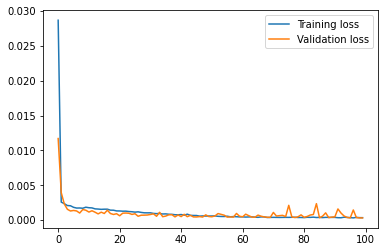

In [11]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

X_test shape == (1261, 5, 3).
y_test shape == (1261, 1).
Predicted shape == (1261, 1).
The model is about 92 % accurate in predicting the next 1261 observations.


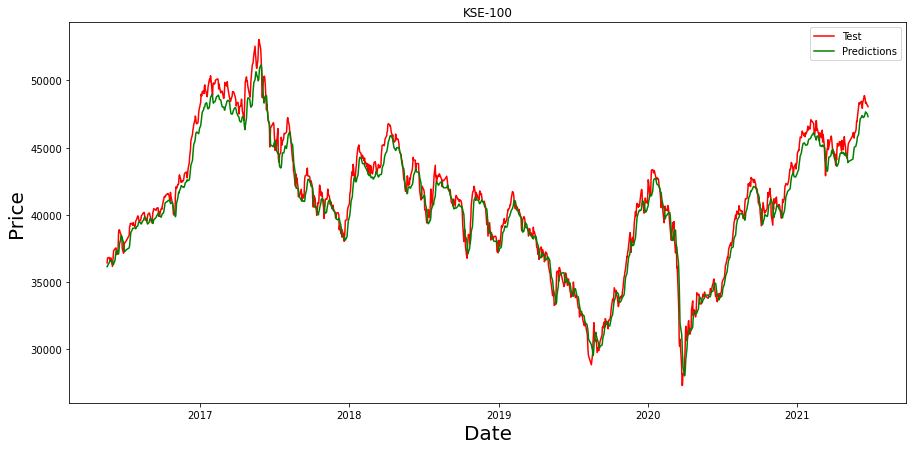

In [12]:
X_test_100 , y_test_100 = create_dataSet(test_data_100,past,future) # Split test data to x and y test

predicted_stock_price_kse100 = model_kse100.predict(X_test_100) # Predict 
print('X_test shape == {}.'.format(X_test_100.shape))
print('y_test shape == {}.'.format(y_test_100.shape))
print('Predicted shape == {}.'.format(predicted_stock_price_kse100.shape))


dates = df_kse100.index[-len(X_test_100):] # get dates of xtest from original dataset

# Format data to origincal shape so that it can be inverse transformed

# Reshape predicted values
forecast_copies = np.repeat(predicted_stock_price_kse100, df_kse100.shape[1], axis=-1) 
y_pred_future = sc.inverse_transform(forecast_copies)[:,0] # Inverse transform

# Reshape test values
y_test_transformed = np.repeat(y_test_100, df_kse100.shape[1], axis=-1)
y_test_transformed = sc.inverse_transform(y_test_transformed)[:,0] # Inverse transform

## Make dataframe of forecasted and test values along with dates    
df_test_100 = pd.DataFrame({'Date':np.array(dates), 'Predicted':y_pred_future,'Y Test':y_test_transformed})

## Convert date time
df_test_100['Date']=pd.to_datetime(df_test_100['Date'])
df_test_100.index = df_test_100['Date']
df_test_100 = df_test_100.drop('Date',axis=1)


## Plot the values from dataframe
plt.figure(figsize=(15,7))
plt.title("KSE-100")
plt.xlabel("Date",size=20)
plt.ylabel("Price",size=20)
plt.plot(df_test_100['Y Test'], color='red',label='Test')   # Test values
plt.plot(df_test_100['Predicted'], color='green', label='Predictions') # predicted by model
plt.legend(loc='best') #An area specifying the element

# MEAN ABOSULTE PERCENTAGE ERROR
mape = np.mean(np.abs(predicted_stock_price_kse100 - y_test_100)/np.abs(y_test_100))
print(f"The model is about {round((1-mape)*100)} % accurate in predicting the next {len(predicted_stock_price_kse100)} observations.")

In [13]:
# Results of predicted and test
df_test_100

,Predicted,Y Test
Date,,
2016-05-18,36152.238281,36429.719441
2016-05-19,36175.320312,36797.759785
2016-05-20,36275.484375,36806.237435
2016-05-23,36440.703125,36836.185107
2016-05-24,36516.929688,36694.723739
...,...,...
2021-06-17,47663.949219,48307.879428
2021-06-18,47620.593750,48389.184601
2021-06-21,47514.089844,48162.294611


### Training 100% Data for model saving

In [14]:
past = 5 # Number of past days we want to use to predict the future
future = 1 # Number of days we want top predict into the future
batch_size = 32  # Look at the past_days of data collectively to identify features
epochs = 100
split_percent = 1
filename = "./indexData/KSE-100.csv"
model_kse100_final,history = start_process(filename,past,future,batch_size,epochs,split_percent)

Train Data shape = (5061, 4).
Test Data shape = (0, 4). 

X_train shape = (5056, 5, 3).
y_train shape = (5056, 1).
Epoch 1/100
143/143 [==============================] - 5s 16ms/step - loss: 0.0966 - mae: 0.2064 - mape: 43.1831 - val_loss: 0.0020 - val_mae: 0.0341 - val_mape: 16.9600
Epoch 2/100
143/143 [==============================] - 1s 9ms/step - loss: 0.0028 - mae: 0.0410 - mape: 9.9637 - val_loss: 0.0016 - val_mae: 0.0292 - val_mape: 16.0951
Epoch 3/100
143/143 [==============================] - 1s 10ms/step - loss: 0.0023 - mae: 0.0375 - mape: 9.9152 - val_loss: 0.0015 - val_mae: 0.0276 - val_mape: 15.3691
Epoch 4/100
143/143 [==============================] - 1s 10ms/step - loss: 0.0021 - mae: 0.0356 - mape: 9.9255 - val_loss: 0.0015 - val_mae: 0.0293 - val_mape: 14.7938
Epoch 5/100
143/143 [==============================] - 2s 11ms/step - loss: 0.0019 - mae: 0.0330 - mape: 7.9733 - val_loss: 0.0016 - val_mae: 0.0310 - val_mape: 14.6471
Epoch 6/100
143/143 [===================

143/143 [==============================] - 1s 9ms/step - loss: 0.0014 - mae: 0.0270 - mape: 8.9603 - val_loss: 8.4197e-04 - val_mae: 0.0219 - val_mape: 10.4489
Epoch 49/100
143/143 [==============================] - 1s 10ms/step - loss: 0.0013 - mae: 0.0267 - mape: 10.0567 - val_loss: 7.6710e-04 - val_mae: 0.0203 - val_mape: 10.4711
Epoch 50/100
143/143 [==============================] - 1s 10ms/step - loss: 0.0014 - mae: 0.0279 - mape: 10.3609 - val_loss: 8.2823e-04 - val_mae: 0.0216 - val_mape: 10.3293
Epoch 51/100
143/143 [==============================] - 1s 9ms/step - loss: 0.0013 - mae: 0.0266 - mape: 8.8326 - val_loss: 0.0011 - val_mae: 0.0253 - val_mape: 11.6956
Epoch 52/100
143/143 [==============================] - 2s 12ms/step - loss: 0.0015 - mae: 0.0282 - mape: 8.9108 - val_loss: 7.6382e-04 - val_mae: 0.0207 - val_mape: 10.1515
Epoch 53/100
143/143 [==============================] - 1s 9ms/step - loss: 0.0013 - mae: 0.0258 - mape: 9.9903 - val_loss: 0.0014 - val_mae: 0.029

Epoch 96/100
143/143 [==============================] - 1s 9ms/step - loss: 0.0012 - mae: 0.0246 - mape: 8.5862 - val_loss: 5.0216e-04 - val_mae: 0.0164 - val_mape: 7.9274
Epoch 97/100
143/143 [==============================] - 1s 9ms/step - loss: 0.0014 - mae: 0.0261 - mape: 9.0256 - val_loss: 0.0013 - val_mae: 0.0314 - val_mape: 10.2493
Epoch 98/100
143/143 [==============================] - 1s 9ms/step - loss: 0.0013 - mae: 0.0255 - mape: 8.3510 - val_loss: 5.6380e-04 - val_mae: 0.0182 - val_mape: 8.0075
Epoch 99/100
143/143 [==============================] - 2s 13ms/step - loss: 0.0014 - mae: 0.0254 - mape: 7.6178 - val_loss: 0.0014 - val_mae: 0.0307 - val_mape: 11.5847
Epoch 100/100
143/143 [==============================] - 1s 10ms/step - loss: 0.0014 - mae: 0.0262 - mape: 9.6486 - val_loss: 0.0011 - val_mae: 0.0289 - val_mape: 9.9026


In [15]:
## Saving the Model
save_model(model_kse100_final,'KSE-100')

In [58]:
### Loading the model and predicting ahead with given dataset
model_kse100_final = load_model('./LSTM_MODELS/KSE-100.h5')
forecast_kse100 = forecast(model_kse100_final,5,df_100)
forecast_kse100

,Date,Close
0,2021-06-23,47875.082031
1,2021-06-24,47499.828125
2,2021-06-25,47524.921875
3,2021-06-28,47459.382812
4,2021-06-29,47299.640625


# KSE ALL Index

In [17]:
df_kse_all = load_dataset("./indexData/KSE-All.csv") # Load dataset

train_dates = pd.to_datetime(df_kse_all.index) # Get dates from dataframe

train_data_all,test_data_all = split_data(df_kse_all,0.75) # 75% training and 25% testing

past = 5 # Number of past days we want to use to predict the future
future = 1 # Number of days we want top predict into the future
batch_size = 16  # Look at the past_days of data collectively to identify features
epochs = 100 

X_train_kseAll , y_train_kseAll = create_dataSet(train_data_all,past,future) # Splitting data to x and y train

print('X_train shape = {}.'.format(X_train_kseAll.shape))
print('y_train shape = {}.'.format(y_train_kseAll.shape))

## Call Function with all parameters and get a model ( For testing purpose )
history, model_kseAll = lstm_predict(X_train_kseAll,y_train_kseAll,epochs,batch_size,past) 

X_train shape = (2470, 5, 3).
y_train shape = (2470, 1).
Epoch 1/100
139/139 [==============================] - 7s 24ms/step - loss: 0.0959 - mae: 0.2062 - mape: 57.7383 - val_loss: 0.0035 - val_mae: 0.0455 - val_mape: 5.9493
Epoch 2/100
139/139 [==============================] - 1s 9ms/step - loss: 0.0024 - mae: 0.0372 - mape: 16.2062 - val_loss: 0.0025 - val_mae: 0.0386 - val_mape: 5.1002
Epoch 3/100
139/139 [==============================] - 1s 10ms/step - loss: 0.0022 - mae: 0.0351 - mape: 14.1268 - val_loss: 0.0021 - val_mae: 0.0373 - val_mape: 5.4848
Epoch 4/100
139/139 [==============================] - 1s 9ms/step - loss: 0.0018 - mae: 0.0324 - mape: 14.0200 - val_loss: 0.0020 - val_mae: 0.0345 - val_mape: 4.6496
Epoch 5/100
139/139 [==============================] - 1s 9ms/step - loss: 0.0017 - mae: 0.0315 - mape: 15.2169 - val_loss: 0.0013 - val_mae: 0.0288 - val_mape: 4.0463
Epoch 6/100
139/139 [==============================] - 1s 9ms/step - loss: 0.0020 - mae: 0.0338 - map

139/139 [==============================] - 1s 8ms/step - loss: 0.0013 - mae: 0.0276 - mape: 14.9441 - val_loss: 0.0020 - val_mae: 0.0366 - val_mape: 5.3266
Epoch 50/100
139/139 [==============================] - 1s 9ms/step - loss: 0.0011 - mae: 0.0250 - mape: 14.5712 - val_loss: 0.0012 - val_mae: 0.0275 - val_mape: 3.9200
Epoch 51/100
139/139 [==============================] - 1s 9ms/step - loss: 0.0013 - mae: 0.0280 - mape: 13.1346 - val_loss: 0.0014 - val_mae: 0.0297 - val_mape: 4.3265
Epoch 52/100
139/139 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0254 - mape: 16.2668 - val_loss: 9.6951e-04 - val_mae: 0.0242 - val_mape: 3.3580
Epoch 53/100
139/139 [==============================] - 1s 9ms/step - loss: 0.0011 - mae: 0.0259 - mape: 14.2244 - val_loss: 8.6553e-04 - val_mae: 0.0229 - val_mape: 3.2367
Epoch 54/100
139/139 [==============================] - 1s 8ms/step - loss: 0.0013 - mae: 0.0278 - mape: 11.4706 - val_loss: 9.0763e-04 - val_mae: 0.0234 - val_

Epoch 97/100
139/139 [==============================] - 1s 7ms/step - loss: 0.0010 - mae: 0.0243 - mape: 10.9360 - val_loss: 0.0013 - val_mae: 0.0297 - val_mape: 4.2160
Epoch 98/100
139/139 [==============================] - 1s 7ms/step - loss: 0.0010 - mae: 0.0239 - mape: 17.3528 - val_loss: 0.0012 - val_mae: 0.0285 - val_mape: 3.9938
Epoch 99/100
139/139 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0246 - mape: 17.3618 - val_loss: 9.7582e-04 - val_mae: 0.0253 - val_mape: 3.5355
Epoch 100/100
139/139 [==============================] - 1s 8ms/step - loss: 9.8961e-04 - mae: 0.0236 - mape: 14.2079 - val_loss: 5.7249e-04 - val_mae: 0.0186 - val_mape: 2.6681


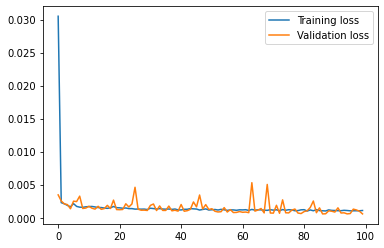

In [18]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

X_test shape == (820, 5, 3).
y_test shape == (820, 1).
Predicted shape == (820, 1).
The model is about 94 % accurate in predicting the next 820 observations.


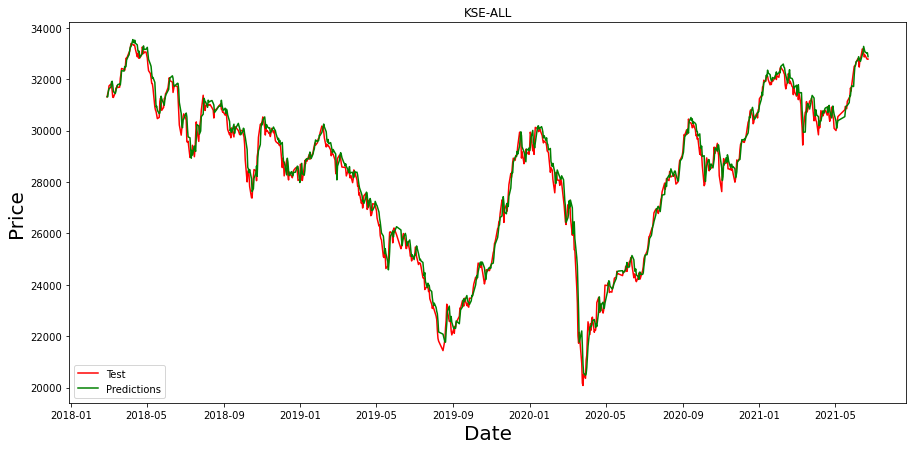

In [19]:
X_test_kseAll , y_test_kseAll = create_dataSet(test_data_all,past,future) # Split test data to x and y test

predicted_stock_price_kseAll = model_kseAll.predict(X_test_kseAll) # Predict 
print('X_test shape == {}.'.format(X_test_kseAll.shape))
print('y_test shape == {}.'.format(y_test_kseAll.shape))
print('Predicted shape == {}.'.format(predicted_stock_price_kseAll.shape))


dates = df_kse_all.index[-len(X_test_kseAll):] # get dates of xtest from original dataset

# Format data to origincal shape so that it can be inverse transformed

# Reshape predicted values
forecast_copies = np.repeat(predicted_stock_price_kseAll, df_kse_all.shape[1], axis=-1) 
y_pred_future = sc.inverse_transform(forecast_copies)[:,0] # Inverse transform

# Reshape test values
y_test_transformed = np.repeat(y_test_kseAll, df_kse_all.shape[1], axis=-1)
y_test_transformed = sc.inverse_transform(y_test_transformed)[:,0] # Inverse transform

## Make dataframe of forecasted and test values along with dates    
df_test_kseAll = pd.DataFrame({'Date':np.array(dates), 'Predicted':y_pred_future,'Y Test':y_test_transformed})

## Convert date time
df_test_kseAll['Date']=pd.to_datetime(df_test_kseAll['Date'])
df_test_kseAll.index = df_test_kseAll['Date']
df_test_kseAll = df_test_kseAll.drop('Date',axis=1)


## Plot the values from dataframe
plt.figure(figsize=(15,7))
plt.title("KSE-ALL")
plt.xlabel("Date",size=20)
plt.ylabel("Price",size=20)
plt.plot(df_test_kseAll['Y Test'], color='red',label='Test')   # Test values
plt.plot(df_test_kseAll['Predicted'], color='green', label='Predictions') # predicted by model
plt.legend(loc='best') #An area specifying the element

# MEAN ABOSULTE PERCENTAGE ERROR
mape = np.mean(np.abs(predicted_stock_price_kseAll - y_test_kseAll)/np.abs(y_test_kseAll))
print(f"The model is about {round((1-mape)*100)} % accurate in predicting the next {len(predicted_stock_price_kseAll)} observations.")

In [20]:
# Results ( Predicted and Test for KSE All Index)
df_test_kseAll

,Predicted,Y Test
Date,,
2018-02-27,31320.201172,31307.442995
2018-02-28,31316.158203,31441.598112
2018-03-01,31532.125000,31521.483393
2018-03-02,31619.251953,31736.777483
2018-03-05,31696.550781,31808.207862
...,...,...
2021-06-17,33160.179688,32863.455810
2021-06-18,33065.203125,32943.010115
2021-06-21,33013.480469,32796.388280


## Training 100% Data of KSE ALL 

In [22]:
past = 5 # Number of past days we want to use to predict the future
future = 1 # Number of days we want top predict into the future
batch_size = 16  # Look at the past_days of data collectively to identify features
epochs = 100
split_percent = 1 # Use 100% data for training
filename = "./indexData/KSE-All.csv"
model_kse_All_Final,history = start_process(filename,past,future,batch_size,epochs,split_percent)

Train Data shape = (3300, 4).
Test Data shape = (0, 4). 

X_train shape = (3295, 5, 3).
y_train shape = (3295, 1).
Epoch 1/100
186/186 [==============================] - 8s 20ms/step - loss: 0.0539 - mae: 0.1413 - mape: 38.9161 - val_loss: 0.0016 - val_mae: 0.0286 - val_mape: 18.7576
Epoch 2/100
186/186 [==============================] - 2s 9ms/step - loss: 0.0026 - mae: 0.0389 - mape: 13.8085 - val_loss: 0.0016 - val_mae: 0.0277 - val_mape: 19.3694
Epoch 3/100
186/186 [==============================] - 1s 8ms/step - loss: 0.0024 - mae: 0.0373 - mape: 12.4097 - val_loss: 0.0016 - val_mae: 0.0300 - val_mape: 18.2514
Epoch 4/100
186/186 [==============================] - 2s 9ms/step - loss: 0.0021 - mae: 0.0353 - mape: 11.2870 - val_loss: 0.0015 - val_mae: 0.0269 - val_mape: 18.7540
Epoch 5/100
186/186 [==============================] - 2s 8ms/step - loss: 0.0019 - mae: 0.0340 - mape: 11.1878 - val_loss: 0.0015 - val_mae: 0.0288 - val_mape: 18.0526
Epoch 6/100
186/186 [==================

186/186 [==============================] - 2s 12ms/step - loss: 0.0019 - mae: 0.0327 - mape: 11.9989 - val_loss: 0.0013 - val_mae: 0.0313 - val_mape: 12.2451
Epoch 49/100
186/186 [==============================] - 2s 13ms/step - loss: 0.0016 - mae: 0.0294 - mape: 8.8865 - val_loss: 0.0015 - val_mae: 0.0349 - val_mape: 12.7414
Epoch 50/100
186/186 [==============================] - 2s 13ms/step - loss: 0.0016 - mae: 0.0301 - mape: 12.0070 - val_loss: 6.7045e-04 - val_mae: 0.0201 - val_mape: 10.8429
Epoch 51/100
186/186 [==============================] - 3s 14ms/step - loss: 0.0017 - mae: 0.0310 - mape: 10.9448 - val_loss: 5.6190e-04 - val_mae: 0.0169 - val_mape: 9.8725
Epoch 52/100
186/186 [==============================] - 2s 12ms/step - loss: 0.0016 - mae: 0.0297 - mape: 9.0379 - val_loss: 6.9311e-04 - val_mae: 0.0195 - val_mape: 10.3111
Epoch 53/100
186/186 [==============================] - 2s 11ms/step - loss: 0.0016 - mae: 0.0291 - mape: 10.1559 - val_loss: 6.1239e-04 - val_mae: 0

186/186 [==============================] - 2s 8ms/step - loss: 0.0015 - mae: 0.0286 - mape: 10.0994 - val_loss: 5.5947e-04 - val_mae: 0.0172 - val_mape: 9.1862
Epoch 96/100
186/186 [==============================] - 2s 8ms/step - loss: 0.0015 - mae: 0.0294 - mape: 9.9263 - val_loss: 7.7957e-04 - val_mae: 0.0233 - val_mape: 9.3826
Epoch 97/100
186/186 [==============================] - 2s 9ms/step - loss: 0.0016 - mae: 0.0295 - mape: 11.6411 - val_loss: 5.7140e-04 - val_mae: 0.0186 - val_mape: 8.7856
Epoch 98/100
186/186 [==============================] - 2s 9ms/step - loss: 0.0015 - mae: 0.0288 - mape: 10.8159 - val_loss: 4.6062e-04 - val_mae: 0.0156 - val_mape: 8.4132
Epoch 99/100
186/186 [==============================] - 2s 8ms/step - loss: 0.0015 - mae: 0.0289 - mape: 8.8560 - val_loss: 5.4512e-04 - val_mae: 0.0181 - val_mape: 8.4627
Epoch 100/100
186/186 [==============================] - 2s 8ms/step - loss: 0.0016 - mae: 0.0297 - mape: 9.3128 - val_loss: 6.5622e-04 - val_mae: 0.0

In [23]:
## Saving the Model
save_model(model_kse_All_Final,'KSE-All')

In [57]:
### Loading the model and predicting ahead with given dataset
model_kse_All_Final = load_model('./LSTM_MODELS/KSE-All.h5')
forecast_kseAll = forecast(model_kse_All_Final,5,df_kse_all)
forecast_kseAll

,Date,Close
0,2021-06-23,32677.416016
1,2021-06-24,32557.107422
2,2021-06-25,32546.240234
3,2021-06-28,32553.423828
4,2021-06-29,32380.980469


# KSE-30 Index

In [46]:
df_kse_30 = load_dataset("./indexData/KSE-30 Index.csv") # Load dataset

train_dates = pd.to_datetime(df_kse_30.index) # Get dates from dataframe

train_data_Kse30,test_data_Kse30 = split_data(df_kse_30,0.70) # 70% training and 25% testing

past = 10 # Number of past days we want to use to predict the future
future = 1 # Number of days we want top predict into the future
batch_size = 32  # Look at the past_days of data collectively to identify features
epochs = 100 

X_train_kse30 , y_train_kse30 = create_dataSet(train_data_Kse30,past,future) # Splitting data to x and y train

print('X_train shape = {}.'.format(X_train_kse30.shape))
print('y_train shape = {}.'.format(y_train_kse30.shape))

## Call Function with all parameters and get a model ( For testing purpose )
history, model_kse30 = lstm_predict(X_train_kse30,y_train_kse30,epochs,batch_size,past) 

X_train shape = (2552, 10, 3).
y_train shape = (2552, 1).
Epoch 1/100
72/72 [==============================] - 8s 43ms/step - loss: 0.0356 - mae: 0.1280 - mape: 61.9925 - val_loss: 0.0044 - val_mae: 0.0481 - val_mape: 12.1361
Epoch 2/100
72/72 [==============================] - 1s 19ms/step - loss: 0.0027 - mae: 0.0396 - mape: 35.7788 - val_loss: 0.0055 - val_mae: 0.0555 - val_mape: 12.9639
Epoch 3/100
72/72 [==============================] - 1s 19ms/step - loss: 0.0026 - mae: 0.0373 - mape: 43.9101 - val_loss: 0.0050 - val_mae: 0.0532 - val_mape: 12.4954
Epoch 4/100
72/72 [==============================] - 1s 18ms/step - loss: 0.0022 - mae: 0.0353 - mape: 42.7586 - val_loss: 0.0050 - val_mae: 0.0535 - val_mape: 12.3994
Epoch 5/100
72/72 [==============================] - 2s 21ms/step - loss: 0.0022 - mae: 0.0352 - mape: 37.1322 - val_loss: 0.0043 - val_mae: 0.0496 - val_mape: 11.6617
Epoch 6/100
72/72 [==============================] - 2s 23ms/step - loss: 0.0019 - mae: 0.0330 - mape:

Epoch 49/100
72/72 [==============================] - 1s 11ms/step - loss: 0.0010 - mae: 0.0239 - mape: 16.5874 - val_loss: 7.8684e-04 - val_mae: 0.0211 - val_mape: 5.4436
Epoch 50/100
72/72 [==============================] - 1s 12ms/step - loss: 0.0010 - mae: 0.0242 - mape: 28.9462 - val_loss: 0.0010 - val_mae: 0.0242 - val_mape: 5.7854
Epoch 51/100
72/72 [==============================] - 1s 11ms/step - loss: 9.4379e-04 - mae: 0.0227 - mape: 18.7254 - val_loss: 6.6048e-04 - val_mae: 0.0190 - val_mape: 4.9834
Epoch 52/100
72/72 [==============================] - 1s 12ms/step - loss: 9.8241e-04 - mae: 0.0238 - mape: 22.2679 - val_loss: 5.3359e-04 - val_mae: 0.0183 - val_mape: 5.1360
Epoch 53/100
72/72 [==============================] - 1s 11ms/step - loss: 8.9599e-04 - mae: 0.0227 - mape: 19.2627 - val_loss: 6.8895e-04 - val_mae: 0.0195 - val_mape: 5.0287
Epoch 54/100
72/72 [==============================] - 1s 11ms/step - loss: 9.4397e-04 - mae: 0.0233 - mape: 16.2520 - val_loss: 5.61

Epoch 96/100
72/72 [==============================] - 1s 15ms/step - loss: 7.9511e-04 - mae: 0.0212 - mape: 17.3218 - val_loss: 6.4432e-04 - val_mae: 0.0195 - val_mape: 5.0782
Epoch 97/100
72/72 [==============================] - 1s 14ms/step - loss: 8.0097e-04 - mae: 0.0210 - mape: 45.0728 - val_loss: 4.4867e-04 - val_mae: 0.0157 - val_mape: 4.3948
Epoch 98/100
72/72 [==============================] - 1s 14ms/step - loss: 0.0010 - mae: 0.0231 - mape: 21.6351 - val_loss: 4.4323e-04 - val_mae: 0.0154 - val_mape: 4.2230
Epoch 99/100
72/72 [==============================] - 1s 15ms/step - loss: 8.8979e-04 - mae: 0.0217 - mape: 26.8289 - val_loss: 8.8332e-04 - val_mae: 0.0232 - val_mape: 5.5877
Epoch 100/100
72/72 [==============================] - 1s 14ms/step - loss: 8.5420e-04 - mae: 0.0213 - mape: 27.5552 - val_loss: 6.1538e-04 - val_mae: 0.0187 - val_mape: 4.7385


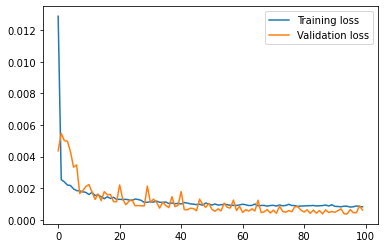

In [47]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

X_test shape == (1088, 10, 3).
y_test shape == (1088, 1).
Predicted shape == (1088, 1).
The model is about 75 % accurate in predicting the next 1088 observations.


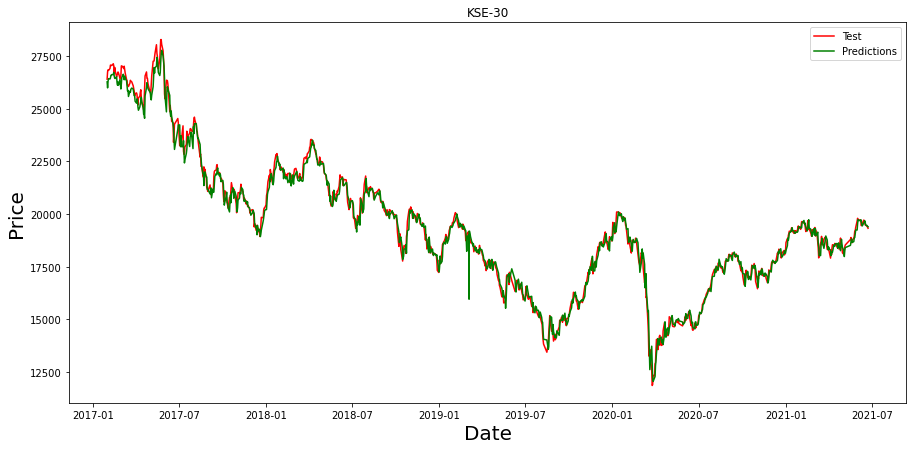

In [48]:
X_test_kse30 , y_test_kse30 = create_dataSet(test_data_Kse30,past,future) # Split test data to x and y test

predicted_stock_price_kse30 = model_kse30.predict(X_test_kse30) # Predict 
print('X_test shape == {}.'.format(X_test_kse30.shape))
print('y_test shape == {}.'.format(y_test_kse30.shape))
print('Predicted shape == {}.'.format(predicted_stock_price_kse30.shape))


dates = df_kse_30.index[-len(X_test_kse30):] # get dates of xtest from original dataset

# Format data to origincal shape so that it can be inverse transformed

# Reshape predicted values
forecast_copies = np.repeat(predicted_stock_price_kse30, df_kse_30.shape[1], axis=-1) 
y_pred_future = sc.inverse_transform(forecast_copies)[:,0] # Inverse transform

# Reshape test values
y_test_transformed = np.repeat(y_test_kse30, df_kse_30.shape[1], axis=-1)
y_test_transformed = sc.inverse_transform(y_test_transformed)[:,0] # Inverse transform

## Make dataframe of forecasted and test values along with dates    
df_test_kse30 = pd.DataFrame({'Date':np.array(dates), 'Predicted':y_pred_future,'Y Test':y_test_transformed})

## Convert date time
df_test_kse30['Date']=pd.to_datetime(df_test_kse30['Date'])
df_test_kse30.index = df_test_kse30['Date']
df_test_kse30 = df_test_kse30.drop('Date',axis=1)


## Plot the values from dataframe
plt.figure(figsize=(15,7))
plt.title("KSE-30")
plt.xlabel("Date",size=20)
plt.ylabel("Price",size=20)
plt.plot(df_test_kse30['Y Test'], color='red',label='Test')   # Test values
plt.plot(df_test_kse30['Predicted'], color='green', label='Predictions') # predicted by model
plt.legend(loc='best') #An area specifying the element

# MEAN ABOSULTE PERCENTAGE ERROR
mape = np.mean(np.abs(predicted_stock_price_kse30 - y_test_kse30)/np.abs(y_test_kse30))
print(f"The model is about {round((1-mape)*100)} % accurate in predicting the next {len(predicted_stock_price_kse30)} observations.")

In [49]:
df_test_kse30

,Predicted,Y Test
Date,,
2017-01-31,26270.148438,26398.722602
2017-02-01,25986.146484,26753.011963
2017-02-02,26307.699219,26842.192236
2017-02-03,26425.490234,26814.528767
2017-02-06,26406.632812,26904.211464
...,...,...
2021-06-17,19626.779297,19483.488264
2021-06-18,19471.599609,19488.070372
2021-06-21,19455.328125,19401.653431


## Training 100% Data of KSE 30 Index 

In [52]:
past = 10 # Number of past days we want to use to predict the future
future = 1 # Number of days we want top predict into the future
batch_size = 32  # Look at the past_days of data collectively to identify features
epochs = 100
split_percent = 1 # Use 100% data for training
filename = "./indexData/KSE-30 Index.csv"
model_kse_30_Final,history = start_process(filename,past,future,batch_size,epochs,split_percent)

Train Data shape = (3660, 4).
Test Data shape = (0, 4). 

X_train shape = (3650, 10, 3).
y_train shape = (3650, 1).
Epoch 1/100
103/103 [==============================] - 7s 27ms/step - loss: 0.0237 - mae: 0.1027 - mape: 50.5919 - val_loss: 0.0029 - val_mae: 0.0355 - val_mape: 55.6336
Epoch 2/100
103/103 [==============================] - 2s 16ms/step - loss: 0.0027 - mae: 0.0396 - mape: 37.8222 - val_loss: 0.0026 - val_mae: 0.0361 - val_mape: 72.2554
Epoch 3/100
103/103 [==============================] - 2s 16ms/step - loss: 0.0024 - mae: 0.0375 - mape: 34.8085 - val_loss: 0.0024 - val_mae: 0.0322 - val_mape: 51.7348
Epoch 4/100
103/103 [==============================] - 2s 17ms/step - loss: 0.0024 - mae: 0.0371 - mape: 31.2312 - val_loss: 0.0022 - val_mae: 0.0306 - val_mape: 49.4588
Epoch 5/100
103/103 [==============================] - 2s 16ms/step - loss: 0.0022 - mae: 0.0354 - mape: 37.6952 - val_loss: 0.0019 - val_mae: 0.0291 - val_mape: 49.5058
Epoch 6/100
103/103 [=============

103/103 [==============================] - 2s 18ms/step - loss: 0.0011 - mae: 0.0246 - mape: 18.4893 - val_loss: 6.0087e-04 - val_mae: 0.0181 - val_mape: 25.0806
Epoch 48/100
103/103 [==============================] - 2s 16ms/step - loss: 0.0012 - mae: 0.0251 - mape: 30.0806 - val_loss: 6.9070e-04 - val_mae: 0.0194 - val_mape: 27.6797
Epoch 49/100
103/103 [==============================] - 2s 17ms/step - loss: 0.0013 - mae: 0.0267 - mape: 26.5737 - val_loss: 5.7517e-04 - val_mae: 0.0172 - val_mape: 25.3568
Epoch 50/100
103/103 [==============================] - 2s 15ms/step - loss: 0.0011 - mae: 0.0240 - mape: 21.2061 - val_loss: 5.5201e-04 - val_mae: 0.0169 - val_mape: 24.5150
Epoch 51/100
103/103 [==============================] - 2s 15ms/step - loss: 0.0011 - mae: 0.0246 - mape: 18.6359 - val_loss: 5.4669e-04 - val_mae: 0.0167 - val_mape: 24.3749
Epoch 52/100
103/103 [==============================] - 2s 16ms/step - loss: 0.0012 - mae: 0.0257 - mape: 18.3185 - val_loss: 5.5125e-04 -

Epoch 94/100
103/103 [==============================] - 2s 21ms/step - loss: 0.0011 - mae: 0.0245 - mape: 22.0222 - val_loss: 5.4943e-04 - val_mae: 0.0170 - val_mape: 23.9788
Epoch 95/100
103/103 [==============================] - 2s 19ms/step - loss: 0.0010 - mae: 0.0237 - mape: 22.4911 - val_loss: 5.2666e-04 - val_mae: 0.0164 - val_mape: 23.1766
Epoch 96/100
103/103 [==============================] - 2s 19ms/step - loss: 0.0010 - mae: 0.0243 - mape: 24.2398 - val_loss: 5.3331e-04 - val_mae: 0.0163 - val_mape: 24.0571
Epoch 97/100
103/103 [==============================] - 2s 22ms/step - loss: 0.0010 - mae: 0.0241 - mape: 20.8036 - val_loss: 5.1271e-04 - val_mae: 0.0161 - val_mape: 22.9484
Epoch 98/100
103/103 [==============================] - 3s 28ms/step - loss: 0.0012 - mae: 0.0247 - mape: 31.0809 - val_loss: 5.3453e-04 - val_mae: 0.0166 - val_mape: 23.8394
Epoch 99/100
103/103 [==============================] - 2s 17ms/step - loss: 0.0012 - mae: 0.0251 - mape: 21.0760 - val_loss:

In [53]:
## Saving the Model
save_model(model_kse_30_Final,'KSE-30')

In [61]:
### Loading the model and predicting ahead with given dataset
df_kse_30 = load_dataset("./indexData/KSE-30 Index.csv") # Load dataset
model_kse_30_Final = load_model('./LSTM_MODELS/KSE-30.h5')
forecast_kse30 = forecast(model_kse_30_Final,5,df_kse_30)
forecast_kse30

,Date,Close
0,2021-06-23,19589.013672
1,2021-06-24,19383.699219
2,2021-06-25,19403.316406
3,2021-06-28,19329.484375
4,2021-06-29,19330.580078
